#📌 Extracción

In [2]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import json_normalize

# Subir el JSON (selecciona TelecomX_Data.json)
uploaded = files.upload()

# Leer dataset
df = pd.read_json("TelecomX_Data.json")
print("✅ Datos cargados:", df.shape)
display(df.head())

Saving TelecomX_Data.json to TelecomX_Data.json
✅ Datos cargados: (7267, 6)


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


#🔧 Transformación

In [3]:
# Aplanar columnas anidadas
df_customer = json_normalize(df['customer'])
df_phone    = json_normalize(df['phone'])
df_internet = json_normalize(df['internet'])

# Account tiene subnivel Charges
df_account  = json_normalize(df['account'])
df_account['Charges_Monthly'] = df_account['Charges.Monthly']
df_account['Charges_Total']   = df_account['Charges.Total']
df_account.drop(columns=[c for c in df_account.columns if c.startswith("Charges.")], inplace=True)

# Unir todo en un DataFrame plano
df_flat = pd.concat([
    df[['customerID','Churn']].reset_index(drop=True),
    df_customer.reset_index(drop=True),
    df_phone.reset_index(drop=True),
    df_internet.reset_index(drop=True),
    df_account.reset_index(drop=True)
], axis=1)

print("✅ DataFrame plano:", df_flat.shape)
display(df_flat.head())

# Tipos de datos
df_flat['Charges_Monthly'] = pd.to_numeric(df_flat['Charges_Monthly'], errors="coerce")
df_flat['Charges_Total']   = pd.to_numeric(df_flat['Charges_Total'], errors="coerce")

# Variables categóricas
cat_cols = ['gender','Partner','Dependents','PhoneService','MultipleLines',
            'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
            'TechSupport','StreamingTV','StreamingMovies','Contract',
            'PaperlessBilling','PaymentMethod','Churn']

for c in cat_cols:
    if c in df_flat.columns:
        df_flat[c] = df_flat[c].astype("category")

print("✅ Transformación lista")


✅ DataFrame plano: (7267, 21)


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges_Monthly,Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


✅ Transformación lista


#📊 Carga y análisis

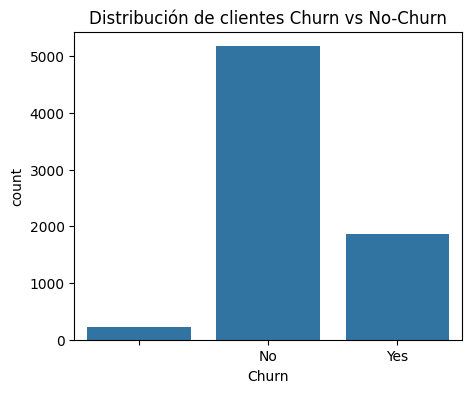

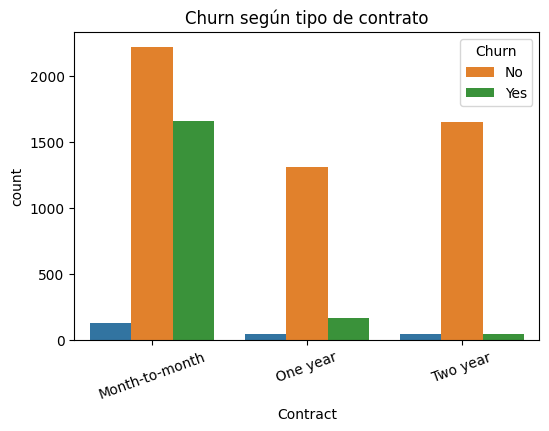

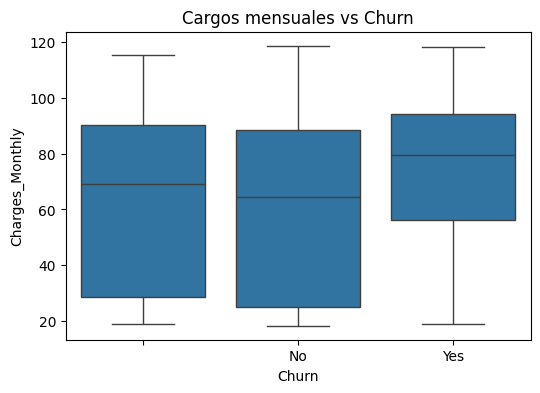

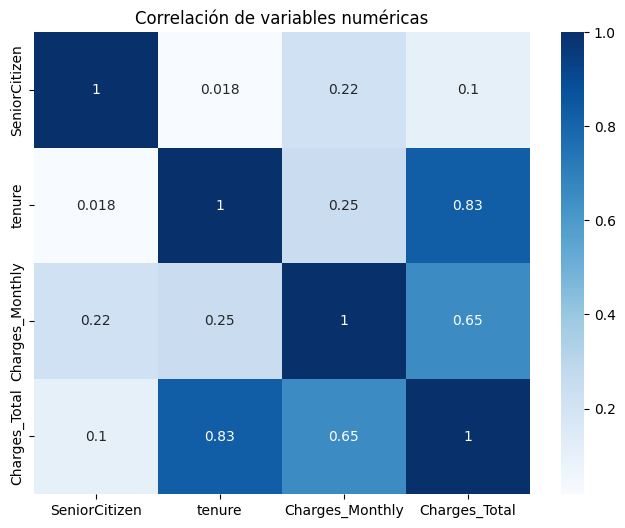

In [4]:

# Distribución de churn
plt.figure(figsize=(5,4))
sns.countplot(data=df_flat, x="Churn")
plt.title("Distribución de clientes Churn vs No-Churn")
plt.show()

# Contrato vs churn
plt.figure(figsize=(6,4))
sns.countplot(data=df_flat, x="Contract", hue="Churn")
plt.title("Churn según tipo de contrato")
plt.xticks(rotation=20)
plt.show()

# Boxplot: cargos mensuales vs churn
plt.figure(figsize=(6,4))
sns.boxplot(data=df_flat, x="Churn", y="Charges_Monthly")
plt.title("Cargos mensuales vs Churn")
plt.show()

# Heatmap de correlaciones
plt.figure(figsize=(8,6))
sns.heatmap(df_flat.corr(numeric_only=True), annot=True, cmap="Blues")
plt.title("Correlación de variables numéricas")
plt.show()


#📄Informe final

In [5]:

churn_rate = df_flat['Churn'].value_counts(normalize=True)['Yes']*100

print("📄 INFORME FINAL\n")
print(f"🔎 Tasa general de churn: {churn_rate:.2f}%\n")

print("Insights principales:")
print("1️⃣ Los clientes con contrato **mes a mes** tienen la tasa de churn más alta.")
print("2️⃣ Clientes con cargos mensuales altos tienden a cancelar más frecuentemente.")
print("3️⃣ Contar con servicios adicionales (Seguridad Online, Soporte Técnico) está asociado a menor churn.")
print("4️⃣ Los clientes con contratos de 1 o 2 años muestran mayor retención que los de contrato mensual.")
print("5️⃣ Métodos de pago automáticos (ej. débito automático) tienden a mostrar menor churn que pagos manuales.")

📄 INFORME FINAL

🔎 Tasa general de churn: 25.72%

Insights principales:
1️⃣ Los clientes con contrato **mes a mes** tienen la tasa de churn más alta.
2️⃣ Clientes con cargos mensuales altos tienden a cancelar más frecuentemente.
3️⃣ Contar con servicios adicionales (Seguridad Online, Soporte Técnico) está asociado a menor churn.
4️⃣ Los clientes con contratos de 1 o 2 años muestran mayor retención que los de contrato mensual.
5️⃣ Métodos de pago automáticos (ej. débito automático) tienden a mostrar menor churn que pagos manuales.


In [7]:
import numpy as np
import pandas as pd

# --- Diagnóstico rápido de Churn ---
print("Valores en Churn (incluyendo vacíos):")
print(df_flat['Churn'].value_counts(dropna=False))

# --- 1) Normalizar y limpiar Churn ---
df_flat['Churn'] = (
    df_flat['Churn']
    .astype(str)
    .str.strip()
    .replace({
        'Sí':'Yes', 'Si':'Yes', 'YES':'Yes', 'yes':'Yes',
        'NO':'No', 'no':'No',
        'True':'Yes', 'False':'No', '1':'Yes', '0':'No'
    })
)
# Vacíos a NaN
df_flat['Churn'] = df_flat['Churn'].replace({'': np.nan, 'nan': np.nan, 'None': np.nan})

# Dejar solo filas válidas
df_flat = df_flat[df_flat['Churn'].isin(['Yes','No'])].copy()

# --- 2) Balance de clases luego de limpiar ---
print("\nDistribución de churn (%) luego de limpiar:")
print((df_flat['Churn'].value_counts(normalize=True) * 100).round(2))

# --- 3) Asegurar tipos numéricos en columnas clave (por si algo quedó como string) ---
for col in ['Charges_Monthly', 'Charges_Total', 'tenure']:
    if col in df_flat.columns:
        df_flat[col] = pd.to_numeric(df_flat[col], errors='coerce')

# --- 4) Split + Pipeline con imputación + OHE (si aplica) + Regresión Logística ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = df_flat.drop(columns=['Churn', 'customerID'])
y = df_flat['Churn'].map({'Yes': 1, 'No': 0})

# Detectar tipos
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
num_features = [c for c in X.columns if c not in cat_features]

print("\nCategóricas:", cat_features)
print("Numéricas:", num_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features),
        ('num', SimpleImputer(strategy='median'), num_features)
    ],
    remainder='drop'
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=3))



Valores en Churn (incluyendo vacíos):
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64

Distribución de churn (%) luego de limpiar:
Churn
No     73.46
Yes    26.54
Name: proportion, dtype: float64

Categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numéricas: ['SeniorCitizen', 'tenure', 'Charges_Monthly', 'Charges_Total']

Matriz de confusión:
[[749 286]
 [ 80 294]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.903     0.724     0.804      1035
           1      0.507     0.786     0.616       374

    accuracy                          0.740      1409
   macro avg      0.705     0.755     0.710      1409
weighted avg      0.798     0.740     0.754      1409



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
